### Agent state and action definition
* State Variable: x = [w, n, M, g_lag, e, s, (H, r, m), O_lag], actions variable a = [c, b, k, i, q] both of them are numpy array. 

In [1]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
import numpy as np
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)


# time line
T_min = 0
T_max = 70
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# utility function parameter 
gamma = 2
# relative importance of housing consumption and non durable consumption 
alpha = 0.8
# parameter used to calculate the housing consumption 
kappa = 0.3
# depreciation parameter 
delta = 0.05
# housing parameter 
chi = 0.3
# uB associated parameter
B = 2
# # minimum consumption 
# c_bar = 3
# constant cost 
c_h = 2
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
r_b = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
# r_k = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_k = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1

# constant state variables: Purchase value 250k, down payment 50k, mortgage 200k, interest rate 3.6%,
# 55 payment period, 8.4k per period. One housing unit is roughly 1 square feet. Housing price 0.25k/sf 

# some variables associate with 401k amount
Nt = [np.sum(Pa[t:]) for t in range(T_max-T_min)]
Dt = [np.ceil(((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)) for N in Nt]
# owning a house 
O_lag = 1
# housing unit
H = 1000
# mortgate rate 
rh = 0.036
# mortgate payment 
m = 8.4
# housing price constant 
pt = 250/1000
# 30k rent 1000 sf
pr = 30/1000

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define the utility function
def u(c):
    # shift utility function to the left, so it only takes positive value
    return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(tb):
    return B*u(tb)

#Calcualte HE 
def calHE(x):
    # change input x as numpy array 
    # w, n, M, g_lag, e, s = x
    HE = (H+(1-chi)*(1-delta)*x[:,3])*pt - x[:,2]
    return HE

#Calculate TB 
def calTB(x):
    # change input x as numpy array
    # w, n, M, g_lag, e, s = x
    TB = x[:,0] + x[:,1] + calHE(x)
    return TB

def R(x, a):
    '''
    Input:
        state x: w, n, M, g_lag, e, s
        action a: c, b, k, i, q = a which is a np array
    Output: 
        reward value: the length of return should be equal to the length of a
    '''
    w, n, M, g_lag, e, s = x
#    c, b, k, i, q = a
#     if q == 1:
#         h = H + (1-delta)*g_lag + i
#         Vh = (1+kappa)*h
#     else:
#         h = H + (1-delta)*g_lag
#         Vh = (1-kappa)*(h-(1-q)*H)
    # The number of reward should be the number of actions taken 
    reward = np.zeros(a.shape[0])
    i_index = (a[:,4]==1)
    ni_index = (a[:,4]!=1)
    
    i_h = H + (1-delta)*g_lag + a[i_index][:,3]
    i_Vh = (1+kappa)*i_h
    
    ni_h = H + (1-delta)*g_lag
    ni_Vh = (1-kappa)*(ni_h-(1-a[ni_index][:,4])*H)
    i_C = np.float_power(a[i_index][:,0], alpha) * np.float_power(i_Vh, 1-alpha)
    ni_C = np.float_power(a[ni_index][:,0], alpha) * np.float_power(ni_Vh, 1-alpha)
    reward[i_index] = u(i_C)
    reward[ni_index] = u(ni_C)
    return reward

#Define the earning function, which applies for both employment and unemployment, good econ state and bad econ state 
def y(t, x):
    w, n, M, g_lag, e, s = x
    if t <= T_R:
        welfare = 5
        return detEarning[t] * earningShock[int(s)] * e + (1-e) * welfare
    else:
        return detEarning[t]
    
#Earning after tax and fixed by transaction in and out from 401k account 
def yAT(t,x):
    yt = y(t, x)
    w, n, M, g_lag, e, s = x
    if t <= T_R and e == 1:
        # 5% of the income will be put into the 401k 
        i = 0.05
        return (1-tau_L)*(yt * (1-i))
    if t <= T_R and e == 0:
        return yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + n/Dt[t]

In [3]:
#Define the evolution of the amount in 401k account 
def gn(t, n, x, s_next):
    w, n, M, g_lag, e, s = x
    if t <= T_R and e == 1:
        # if the person is employed, then 5 percent of his income goes into 401k 
        i = 0.05
        n_cur = n + y(t, x) * i
    elif t <= T_R and e == 0:
        # if the perons is unemployed, then n does not change 
        n_cur = n
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = n - n/Dt[t]
    return (1+r_k[int(s), s_next])*n_cur 

def transition(x, a, t):
    '''
    Input: state and action and time
    Output: possible future states and corresponding probability 
    '''
    w, n, M, g_lag, e, s = x
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    M_next = M*(1+rh) - m
    for aa in a:
        c,b,k,i,q = aa
        if q == 1:
            g = (1-delta)*g_lag + i
        else:
            g = (1-delta)*g_lag
        for s_next in [0,1]:
            w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
            n_next = gn(t, n, x, s_next)
            if t >= T_R:
                e_next = 0
                x_next.append([w_next, n_next, M_next, g, s_next, e_next])
                prob_next.append(Ps[int(s),s_next])
            else:
                for e_next in [0,1]:
                    x_next.append([w_next, n_next, M_next, g, s_next, e_next])
                    prob_next.append(Ps[int(s),s_next] * Pe[int(s),s_next,int(e),e_next])
    return np.array(x_next), np.array(prob_next)

In [4]:
# this part is used for occasionally testing 
# x = np.array([[20,20,20,20,1,1],[20,30,10,20,1,1],[20,20,20,20,1,1],[20,30,10,20,1,1],[20,20,20,20,1,1]])
# a = np.array([[20,20,20,20,1],[20,20,20,0,0.5],[20,20,20,30,1],[20,20,20,0,0.7]])

In [5]:
# used to calculate dot product
def dotProduct(p_next, uBTB, t):
    if t >= 45:
        return (p_next*uBTB).reshape((len(p_next)//2,2)).sum(axis = 1)
    else:
        return (p_next*uBTB).reshape((len(p_next)//4,4)).sum(axis = 1)
    
# Value function is a function of state and time t < T
def V(x, t, NN):
    w, n, M, g_lag, e, s = x
    yat = yAT(t,x)
    if t == T_max-1:
        # The objective functions of terminal state 
        def obj(actions):
            # Not renting out case 
            # a = [c, b, k, i, q]
            x_next, p_next  = transition(x, actions, t)
            uBTB = uB(calTB(x_next)) # conditional on being dead in the future
            return R(x, actions) + beta * dotProduct(uBTB, p_next, t)
    else:
        def obj(actions):
            # Renting out case 
            # a = [c, b, k, i, q]
            x_next, p_next  = transition(x, actions, t)
            V_tilda = NN.predict(x_next) # V_{t+1} conditional on being alive, approximation here
            uBTB = uB(calTB(x_next)) # conditional on being dead in the future
            return R(x, actions) + beta * (Pa[t] * dotProduct(V_tilda, p_next, t) + (1 - Pa[t]) * dotProduct(uBTB, p_next, t))
    
    def obj_solver(obj):
    # Constrain: yat + w - m = c + b + k + (1+chi)*i*pt + I{i>0}*c_h
    # i_portion takes [0:0.05:0.95]
    # c_portion takes remaining [0:0.05:0.95]
    # b_portion takes reamining [0:0.05:0.95]
    # k is the remainder 
        actions = []
        for ip in np.linspace(0,0.9,10):
            budget1 = yat + w - m
            if ip*budget1 > c_h:
                i = (budget1*ip - c_h)/((1+chi)*pt)
                budget2 = budget1 * (1-ip)
            else:
                i = 0
                budget2 = budget1
            for cp in np.linspace(0,1,11):
                c = budget2*cp
                budget3 = budget2 * (1-cp)
                for bp in np.linspace(0,1,11):
                    b = budget3* bp
                    k = budget3 * (1-bp)
                    # q = 1 not renting in this case 
                    actions.append([c,b,k,i,1])
                    
    # Constrain: yat + w - m + (1-q)*H*pr = c + b + k
    # q takes value [0:0.05:0.95]
    # c_portion takes remaining [0:0.05:0.95]
    # b_portion takes reamining [0:0.05:0.95]
    # k is the remainder
        for q in np.linspace(0,0.9,10):
            budget1 = yat + w - m + (1-q)*H*pr
            for cp in np.linspace(0,1,11):
                c = budget1*cp
                budget2 = budget1 * (1-cp)
                for bp in np.linspace(0,1,11):
                    b = budget2* bp
                    k = budget2 * (1-bp)
                    # i = 0, no housing improvement when renting out 
                    actions.append([c,b,k,0,q])            
                               
        actions = np.array(actions)
        values = obj(actions)
        fun = np.max(values)
        ma = actions[np.argmax(values)]
        return fun, ma
    
    fun, action = obj_solver(obj)
    return np.array([fun, action])

In [6]:
# wealth discretization 
# w_grid_size = 15
# w_lower = 10
# w_upper = 10000
# 401k amount discretization 
# n_grid_size = 5
# n_lower = 10
# n_upper = 6000
# power = 2

# wealth discretization 
ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
w_grid_size = len(ws)
# 401k amount discretization 
ns = np.array([1,3,7,14,24,39,63,100,165,385,13255])
n_grid_size = len(ns)
# Mortgage amount, * 0.25 is the housing price per unit
Ms = np.array([100, 200, 400, 600, 800])*0.25
M_grid_size = len(Ms)
# Improvement amount 
gs = np.array([0, 50, 100])
g_grid_size = len(gs)
# def powspace(start, stop, power, num):
#     start = np.power(start, 1/float(power))
#     stop = np.power(stop, 1/float(power))
#     return np.power(np.linspace(start, stop, num=num), power)
# ws = powspace(w_lower, w_upper, power, w_grid_size)
# ns = powspace(n_lower, n_upper, power, n_grid_size)
xgrid = np.array([[w, n, M, g_lag, e, s] 
                            for w in ws
                            for n in ns
                            for M in Ms
                            for g_lag in gs 
                            for e in [0,1]
                            for s in [0,1]
                            ]).reshape((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2,6))

Vgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
cgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
bgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
kgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
igrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
qgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))

### SLSQP with KNN approximation and multidimensional interpolation

In [7]:
class iApproxy(object):
    def __init__(self, points, Vgrid):
        self.V = Vgrid 
        self.p = points
    def predict(self, xx):
        pvalues = np.zeros(xx.shape[0])
        index00 = (xx[:,4] == 0) & (xx[:,5] == 0) 
        index01 = (xx[:,4] == 0) & (xx[:,5] == 1)
        index10 = (xx[:,4] == 1) & (xx[:,5] == 0)
        index11 = (xx[:,4] == 1) & (xx[:,5] == 1)
        pvalues[index00]=interpn(self.p, self.V[:,:,:,:,0,0], xx[index00][:,:4], bounds_error = False, fill_value = None)
        pvalues[index01]=interpn(self.p, self.V[:,:,:,:,0,1], xx[index01][:,:4], bounds_error = False, fill_value = None)
        pvalues[index10]=interpn(self.p, self.V[:,:,:,:,1,0], xx[index10][:,:4], bounds_error = False, fill_value = None)
        pvalues[index11]=interpn(self.p, self.V[:,:,:,:,1,1], xx[index11][:,:4], bounds_error = False, fill_value = None)
        return pvalues

### Value iteration with interpolation approximation

In [8]:
%%time
# value iteration part 
xs = xgrid.reshape((w_grid_size*n_grid_size*M_grid_size*g_grid_size*2*2,6))
pool = Pool()
points = (ws,ns,Ms,gs)
for t in range(T_max-1,T_min-1, -1):
    print(t)
    if t == T_max - 1:
        f = partial(V, t = t, NN = None)
        results = np.array(pool.map(f, xs))
    else:
        approx = iApproxy(points,Vgrid[:,:,:,:,:,:,t+1])
        f = partial(V, t = t, NN = approx)
        results = np.array(pool.map(f, xs))
    Vgrid[:,:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    cgrid[:,:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    bgrid[:,:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    kgrid[:,:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    igrid[:,:,:,:,:,:,t] = np.array([r[3] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    qgrid[:,:,:,:,:,:,t] = np.array([r[4] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
pool.close()

np.save("Vgrid_i", Vgrid)
np.save("cgrid_i", cgrid)
np.save("bgrid_i", bgrid)
np.save("kgrid_i", kgrid)
np.save("igrid_i", igrid)
np.save("qgrid_i", qgrid)

69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
CPU times: user 27.9 s, sys: 4.63 s, total: 32.6 s
Wall time: 38min 34s


25.0
25.0


<Figure size 432x288 with 0 Axes>

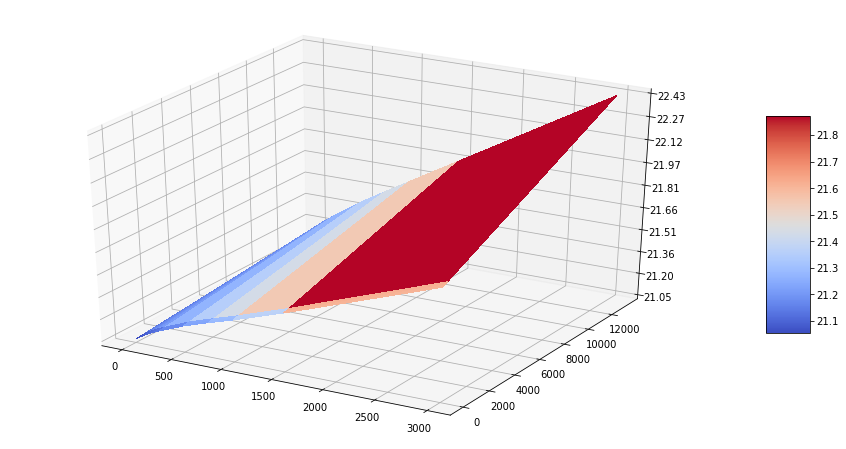

25.0
50.0


<Figure size 432x288 with 0 Axes>

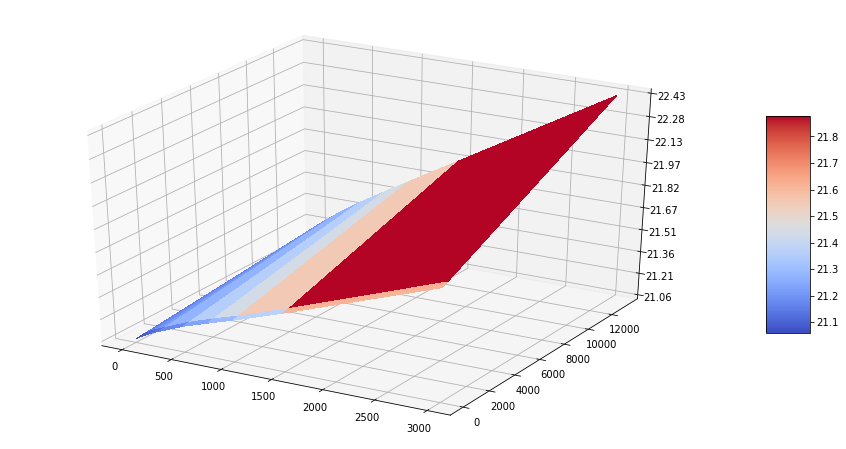

25.0
100.0


<Figure size 432x288 with 0 Axes>

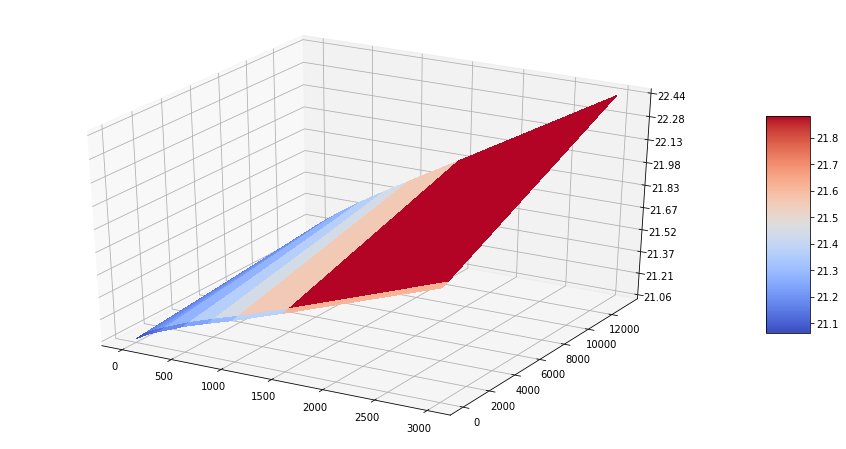

50.0
25.0


<Figure size 432x288 with 0 Axes>

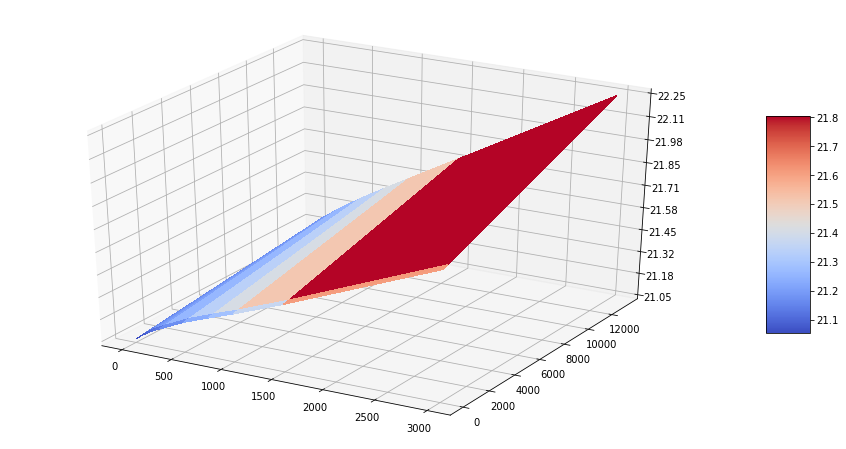

50.0
50.0


<Figure size 432x288 with 0 Axes>

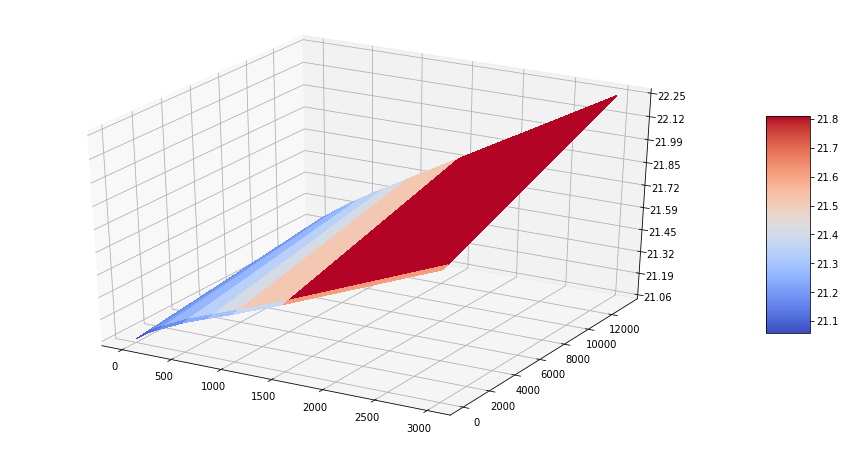

50.0
100.0


<Figure size 432x288 with 0 Axes>

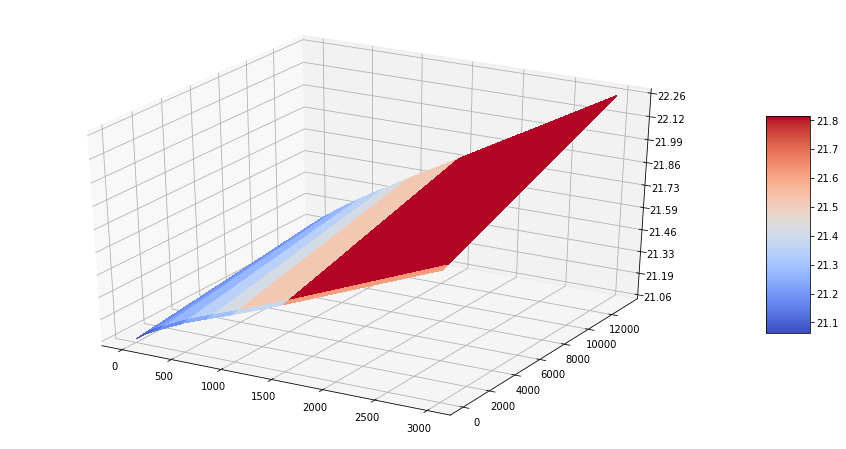

100.0
25.0


<Figure size 432x288 with 0 Axes>

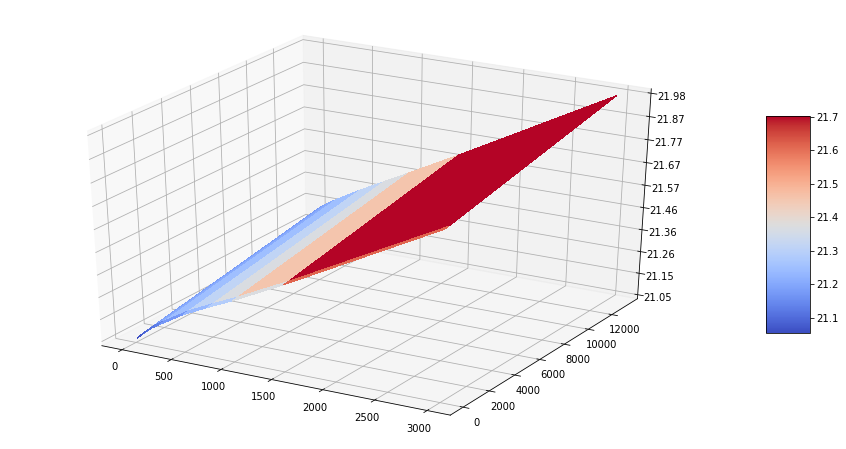

100.0
50.0


<Figure size 432x288 with 0 Axes>

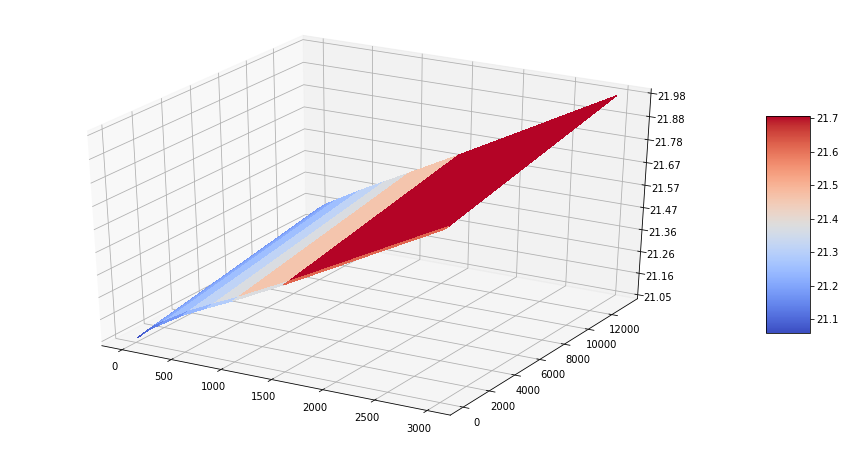

100.0
100.0


<Figure size 432x288 with 0 Axes>

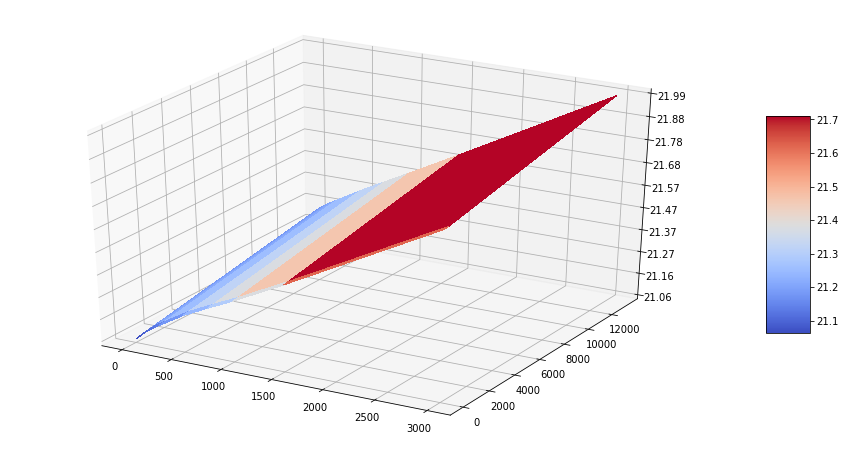

150.0
25.0


<Figure size 432x288 with 0 Axes>

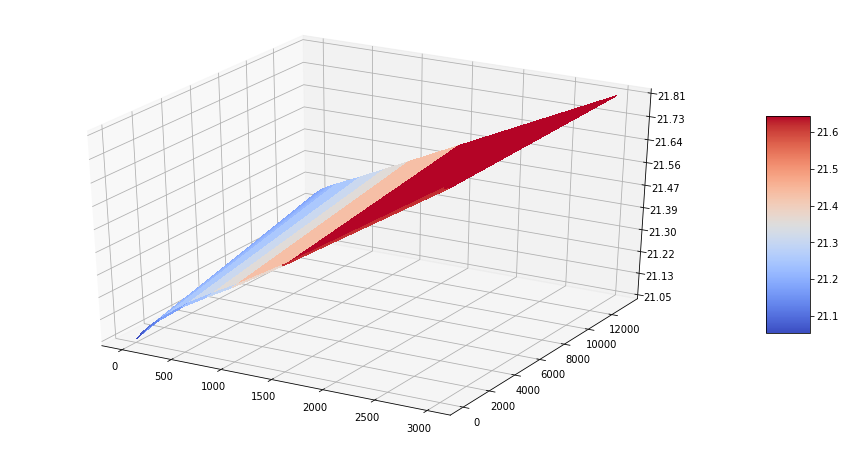

150.0
50.0


<Figure size 432x288 with 0 Axes>

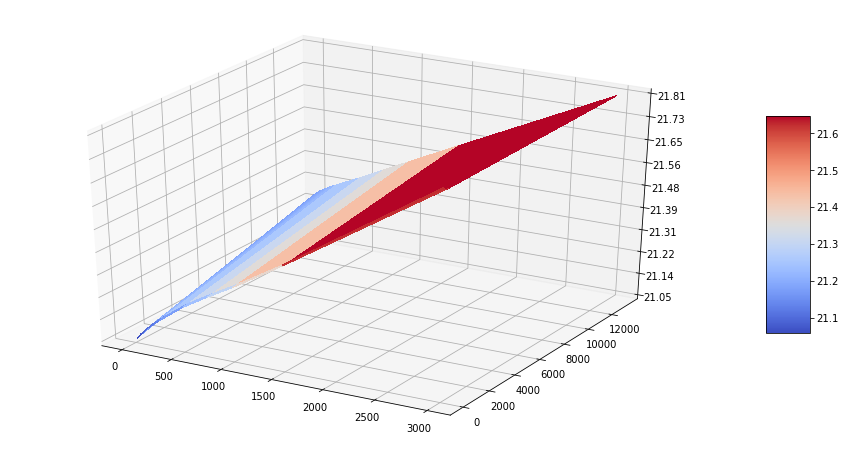

150.0
100.0


<Figure size 432x288 with 0 Axes>

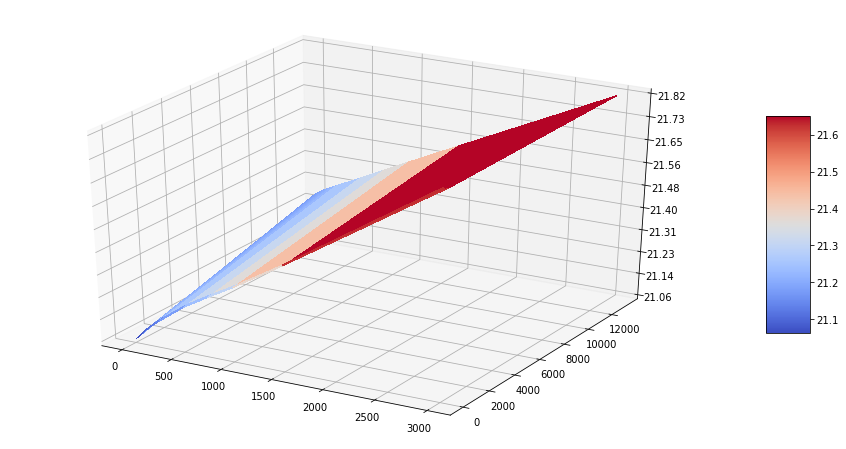

200.0
25.0


<Figure size 432x288 with 0 Axes>

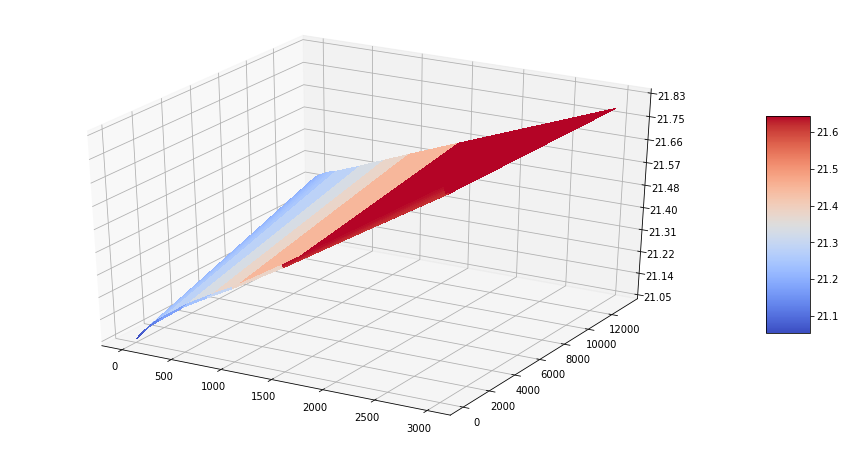

200.0
50.0


<Figure size 432x288 with 0 Axes>

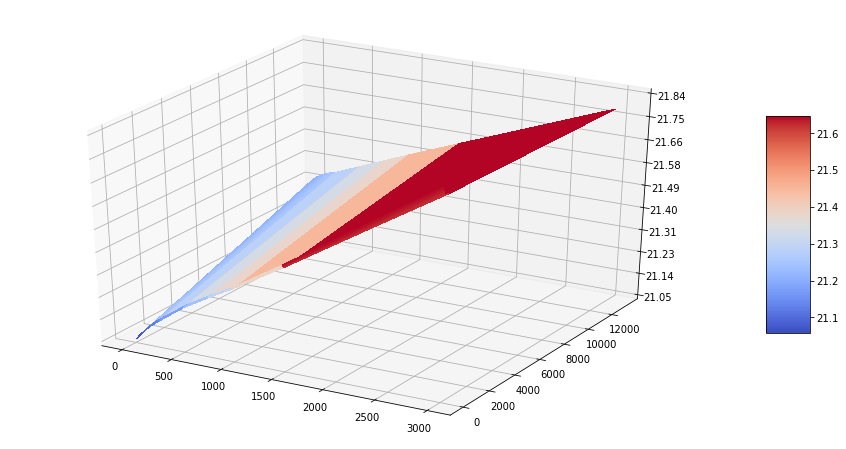

200.0
100.0


<Figure size 432x288 with 0 Axes>

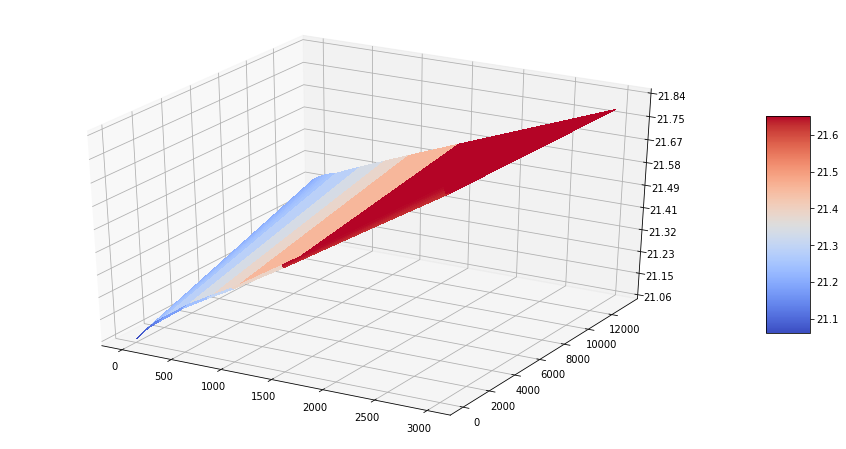

In [20]:
for i in range(len(Ms)):
    for j in range(len(gs)):
        print(Ms[i])
        print(Ms[j])
        plt.figure()  
        surfacePlot(xgrid[:,:,i,j,1,1,0], xgrid[:,:,i,j,1,1,1], Vgrid[:,:,i,j,1,1,t])
        plt.show()

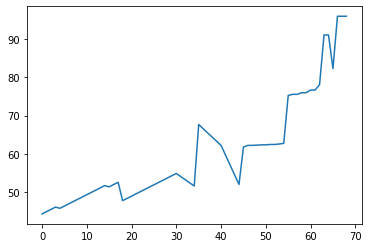

In [10]:
plt.plot(cgrid[4,3,2,2,1,1,:69])

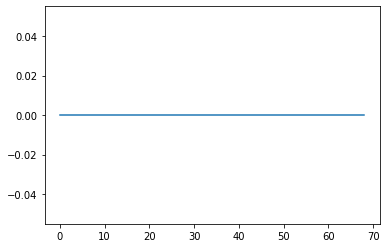

In [11]:
plt.plot(bgrid[4,3,2,2,1,1,:69])

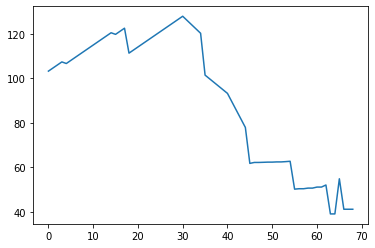

In [12]:
plt.plot(kgrid[4,3,2,2,1,1,:69])

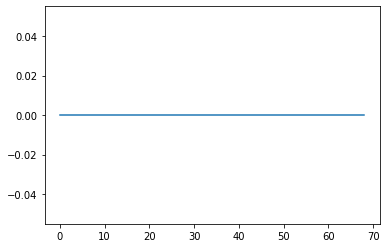

In [13]:
plt.plot(igrid[4,3,2,2,1,1,:69])

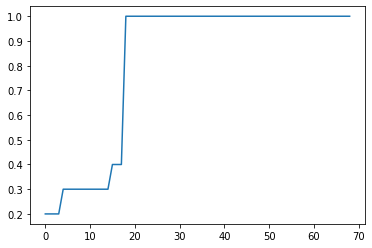

In [14]:
plt.plot(qgrid[4,3,2,2,1,1,:69])